In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm # OLS module for linear regression

my_red = "#f53b3b" # red
my_blue = "#4287f5" # blue

/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_1109/3196362781.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [22]:
spins = [-1, + 1]


def different_states_indicator(a, b):
    value = (1 - a * b)/2
    return value # 1 = different states, 0 = same state
    
def rho(G, state):
    count = 0
    for edge in list(G.edges()):
        start_node = edge[0]
        end_node = edge[1]
        count += different_states_indicator(state[start_node], state[end_node])
    return count/G.size()

def initial_state(num_nodes, spins = spins):
    return [np.random.choice(spins) for _ in range(num_nodes)]

# ASYNCRONOUS UPDATE: one time step corresponds to 
# updating a number of nodes equal to the network size,
#  N, so that on average (!) every node is updated once
def evolution_step(G, state):
    N = G.number_of_nodes()
    degrees = {node: G.degree(node) for node in G.nodes}
    neighbors = {node: list(G.neighbors(node)) for node in G.nodes}
    selected_nodes = np.random.choice(N, N, replace=True)
    for selected_node in selected_nodes:
        if degrees[selected_node] > 0:
            selected_neighbour = np.random.choice(neighbors[selected_node])
            state[selected_node] = state[selected_neighbour]
    return state


# define a Barabasi-Albert graph with node indices sorted by degree in descending order (hubs first)
def ba_graph(num_nodes = 100, mean_degree = 10):
    m = int(mean_degree / 2)
    ba_graph = nx.barabasi_albert_graph(num_nodes, m)
    degrees = dict(ba_graph.degree())
    sorted_indices = sorted(degrees, key=degrees.get, reverse=True)
    new_indices = {old_idx: new_idx for new_idx, old_idx in enumerate(sorted_indices)}
    reindexed_edges = [(new_indices[edge[0]], new_indices[edge[1]]) for edge in ba_graph.edges()]
    reindexed_graph = nx.Graph()
    reindexed_graph.add_edges_from(reindexed_edges) 
    return reindexed_graph


def voter_graph_plot(graph, states, axis):
    colors = []
    for n in range(graph.number_of_nodes()):
        if states[n] == +1:
            colors.append(my_red)
        else:
            colors.append(my_blue)
    positions = nx.spring_layout(graph, seed=42) #by setting the seed, same layout at every run
    nx.draw(graph, ax = axis, pos = positions, node_color = colors, node_size = 5, edge_color = 'lightgrey', width = 0.5)

Text(0, 0.5, 'Node Degree')

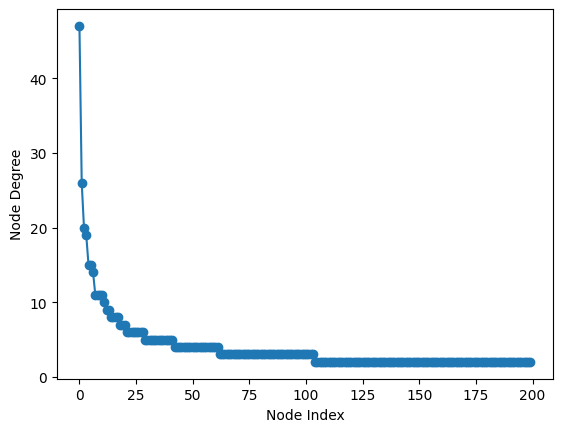

In [19]:
#num_nodes = 10000
#mean_degree = 8
#graph = ba_graph(num_nodes, mean_degree)
#degrees = dict(graph.degree())
#degree_list = [degrees[node] for node in range(num_nodes)]
#fig, ax = plt.subplots()
#ax.plot(range(num_nodes), degree_list, marker='o', linestyle='-')
#ax.set_xlabel('Node Index')
#ax.set_ylabel('Node Degree')

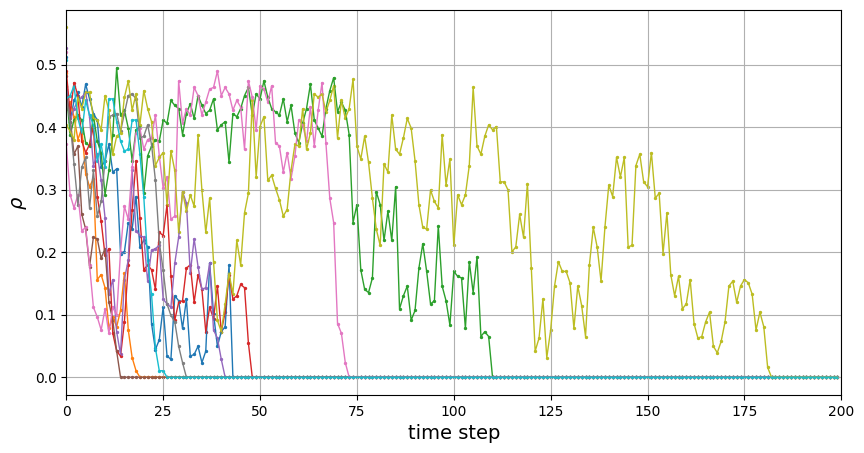

In [36]:
number_of_steps = 200
num_nodes = 100
mean_degree = 8
n_realizations = 10

fig, ax = plt.subplots(figsize = (10, 5))

for n in range(n_realizations):
    data = []
    state = initial_state(num_nodes)
    graph = ba_graph(num_nodes, mean_degree)
    data.append({'step': 0, 'rho': rho(graph, state)})
    for t in range(number_of_steps):
        state = evolution_step(graph, state)
        data.append({'step': t, 'rho': rho(graph, state)})
    df = pd.DataFrame(data)
    df.to_csv(f"csv_outputs/BA_instance_{n}.csv")
    ax.plot(df['step'], df['rho'], linewidth = 1, alpha = 1)
    ax.scatter(df['step'], df['rho'], s = 2)
ax.grid()
ax.set_ylabel(r"$\rho$", fontsize = 14)
ax.set_xlabel("time step", fontsize = 14)
ax.set_xlim(0,200)
#ax.set_title(f"Evolution repeated {n_realizations} times on the same graph")
plt.savefig("figures/example_evolution.pdf")

Text(0.5, 1.0, 'Evolution repeated only once on 10 different network instances')

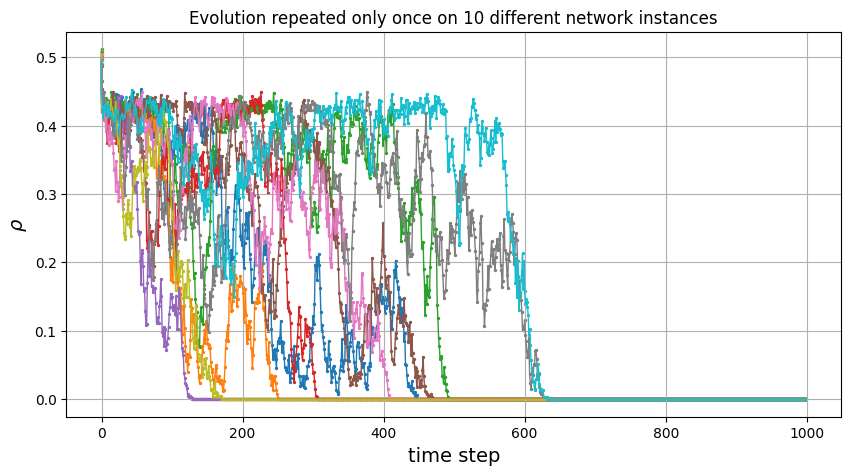

In [84]:
number_of_steps = 1000
num_nodes = 1000
mean_degree = 8
n_realizations = 10

fig, ax = plt.subplots(figsize = (10, 5))

for n in range(n_realizations):
    data = []
    graph = ba_graph(num_nodes, mean_degree)
    state = initial_state(num_nodes)
    data.append({'step': 0, 'rho': rho(graph, state)})
    for t in range(number_of_steps):
        state = evolution_step(graph, state)
        data.append({'step': t, 'rho': rho(graph, state)})
    df = pd.DataFrame(data)
    df.to_csv(f"csv_outputs/BA_instance_{n}.csv")
    ax.plot(df['step'], df['rho'], linewidth = 1, alpha = 1)
    ax.scatter(df['step'], df['rho'], s = 2)
ax.grid()
ax.set_ylabel(r"$\rho$", fontsize = 14)
ax.set_xlabel("time step", fontsize = 14)
ax.set_title(f"Evolution repeated only once on {n_realizations} different network instances")

## Survival time scaling with network size

Question: repeating evolution n times on the same instance of the BA model is the same as repeating evolution exactly once on n different instances?
Might it be that the specific BA instance is somewhat peculiar and does not represent well its ensemble?
I think it is possible.

In the following, I create n_realization different instances of the graph. Also, the random initial state is different for each of them

In [25]:
n_realizations = 500
mean_degree = 6
network_sizes = [1000, 2000, 5000, 10000, 20000, 50000]
time_steps = 1000
df = pd.DataFrame({'time': [t for t in range(time_steps)]})
rho_data = {}

new_sizes = [1500, 2500, 3000, 
             4000]
for size in new_sizes:
    for n in range(n_realizations):
        graph = ba_graph(num_nodes= size, mean_degree=mean_degree)
        state = initial_state(num_nodes= size)
        rho_list = np.zeros(time_steps)
        for t in range(time_steps):
            state = evolution_step(graph, state)
            rho_list[t] = rho(graph, state)
        rho_data[f'instance_{n+1}'] = rho_list
        print(f"size {size}, realization n {n}")
    rho_df = pd.DataFrame(rho_data) # adding columns all at once avoids fragmentation issue and improves performance
    df = pd.concat([df, rho_df], axis=1)
    df['mean'] = df.iloc[:, 1:].mean(axis=1) #calculates row mean, for each row in dataframe
    df.to_csv(f"csv_outputs/size_{size}_n_{n_realizations}.csv", index=False)

size 1500, realization n 0
size 1500, realization n 1
size 1500, realization n 2
size 1500, realization n 3
size 1500, realization n 4
size 1500, realization n 5
size 1500, realization n 6
size 1500, realization n 7
size 1500, realization n 8
size 1500, realization n 9
size 1500, realization n 10
size 1500, realization n 11
size 1500, realization n 12
size 1500, realization n 13
size 1500, realization n 14
size 1500, realization n 15
size 1500, realization n 16
size 1500, realization n 17
size 1500, realization n 18
size 1500, realization n 19
size 1500, realization n 20
size 1500, realization n 21
size 1500, realization n 22
size 1500, realization n 23
size 1500, realization n 24
size 1500, realization n 25
size 1500, realization n 26
size 1500, realization n 27
size 1500, realization n 28
size 1500, realization n 29
size 1500, realization n 30
size 1500, realization n 31
size 1500, realization n 32
size 1500, realization n 33
size 1500, realization n 34
size 1500, realization n 35
si

KeyboardInterrupt: 

A note of mine: I see that rho in the initial condition, averaged over the ensemble, has a fleble but visible dependence on N. It increases with N. 
I thought that I should have expected a constant value of rho = 0.5.
But thinking more carefully, rho actually measures the number of links at the interface, not the number of up/down spins directly. For smaller networrks, boundaries are more important. I think this is the reason why rho increases monotonically with size, and i expect that it whould be 0.5 in the infinite size limit.

You cannot fix the whole exponential because log(0) = -infty

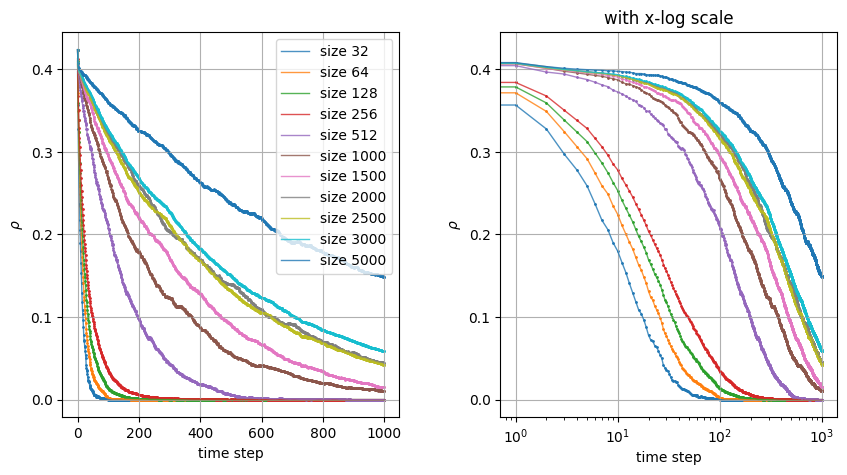

In [74]:
sizes = [32, 64, 128, 256, 512, 1000, 1500, 2000, 2500, 3000, 5000]
endings = [50, 75, 100, 150, 400, 1000, 1000, 1000, 1000, 1000, 1000]
data = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
plt.subplots_adjust(wspace = 0.3)

for i, s in enumerate(sizes):
    df = pd.read_csv(f"csv_outputs/size_{s}_n_{500}.csv")
    ax1.plot(df['time'], df['mean'], linewidth = 1, label = f"size {s}", alpha = 0.8)
    ax1.scatter(df['time'], df['mean'], linewidth = 1, s = 1)

    ax2.plot(df['time'], df['mean'], linewidth = 1, alpha = 0.8)
    ax2.scatter(df['time'], df['mean'], linewidth = 1, s = 1)
    ## exponential fit ##
    x = df['time'].iloc[10:endings[i]].values.reshape(-1, 1)
    y = np.log(df['mean'].iloc[10:endings[i]].values)
    X = sm.add_constant(x)  # this means i also want the intercept
    model = sm.OLS(y, X).fit()
    params = model.params  # a + b * x
    standard_errors = model.bse
    eta = np.exp(params[0])
    sigma_eta = eta * standard_errors[0]
    tau =  - 1 / params[1]
    sigma_tau = np.square(tau) * standard_errors[1]
    data.append({'size': s, 'tau': tau, 'sigma_tau': sigma_tau, 'eta': eta, 'sigma_eta': sigma_eta})

df = pd.DataFrame(data)


df.to_csv("csv_outputs/BA_node_update_rule_results.csv")

ax1.set_xlabel('time step')
ax1.set_ylabel(r'$\rho$')

ax2.set_xlabel('time step')
ax2.set_ylabel(r'$\rho$')

ax2.set_xscale('log')
ax2.set_title("with x-log scale")
ax1.legend()
ax1.grid()
ax2.grid()
plt.savefig("figures/BA_node_update_rule_results_logscale.pdf")

power fit: 0.8311902031806951 +/- 0.0007176002639277179, 0.7067320189857932 +- 0.003956602951301922


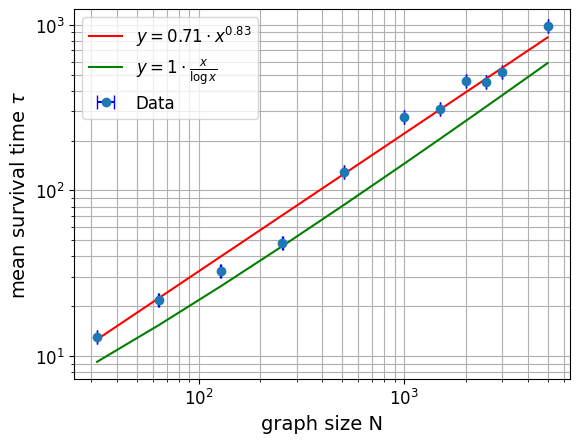

In [64]:
from scipy.optimize import curve_fit

df = pd.read_csv('csv_outputs/BA_node_update_rule_results.csv')

x_data = df['size']
y_data = df['tau']
y_uncertainties = df['sigma_tau']

def power_law(x, gamma, a):
    return a * (x ** gamma)

def linear_function(x, slope):
    return x * slope

# Power Law fit
power_params, power_covariance = curve_fit(power_law, x_data, y_data, sigma=y_uncertainties, absolute_sigma=True)
gamma = power_params[0]
std_gamma = np.sqrt(power_covariance[0,0])
y_power = power_law(x_data, *power_params)


# Linear fit
#linear_params, linear_covariance = curve_fit(linear_function, x_data, y_data, sigma=y_uncertainties, absolute_sigma=True)
#slope = linear_params[0]
#std_slope = np.sqrt(linear_covariance[0,0])
#y_linear = linear_function(x_data, slope)

fig, ax = plt.subplots()
ax.errorbar(x_data, y_data, xerr= y_uncertainties, fmt='o', ecolor='b', capsize=5 , label = "Data")
ax.plot(x_data, y_power, label=rf'$y={power_params[1]:.2f}\cdot x^{{{gamma:.2f}}}$', color='red')
#ax.plot(x_data, y_linear, label=f'linear {slope:.2f} +- {std_slope:.2f}', color='grey')
ax.plot(x_data, [ x / np.log(x) for x in x_data], color = 'green', label = r"$y = 1 \cdot \frac{x}{\log{x}}$")
ax.set_xticks([100, 1000])
ax.set_xticklabels([100, 1000], fontsize = 12)
ax.set_yticks([10, 100, 1000])
ax.set_yticklabels([10, 100, 1000], fontsize = 12)
ax.set_xlabel('graph size N', fontsize = 14)
ax.set_ylabel(r'mean survival time $\tau$', fontsize = 14)
ax.legend(fontsize = 12)
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(which= 'both')
#print(f"linear fit: {slope} +/- {std_slope}")
print(f"power fit: {gamma} +/- {std_gamma}, {power_params[1]} +- {np.sqrt(power_covariance[1,1])}")
plt.savefig("figures/BA_time_scaling.pdf")
plt.show()

## But why didn't you take smaller samples?

Here is why

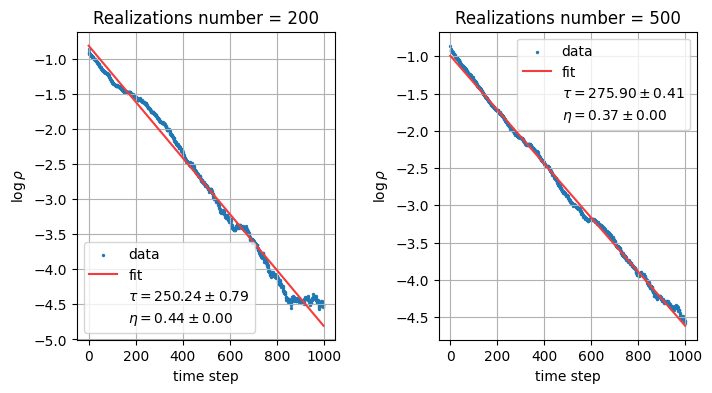

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8,4))
plt.subplots_adjust(wspace = 0.4)
# plot 1: small sample
df = pd.read_csv(f"csv_outputs/size_1000_n_200.csv")
x = df['time'].values.reshape(-1, 1)
y = np.log(df['mean'].values)
X = sm.add_constant(x)  # this means i also want the intercept
model = sm.OLS(y, X).fit()
params = model.params  # a + b * x
standard_errors = model.bse
eta = np.exp(params[0])
sigma_eta = eta * standard_errors[0]
tau =  - 1 / params[1]
sigma_tau = np.square(tau) * standard_errors[1]
data_plot = ax1.scatter(x, y, s =2, label = 'data')
ax1.set_xlabel('time step')
ax1.set_ylabel(r'$\log{\rho}$')
line, = ax1.plot(x, [params[0] + point * params[1] for point in x], color = my_red, label='fit')
invisible_line = plt.Line2D([], [], linestyle="none", label='custom_text')
invisible_line_bis = plt.Line2D([], [], linestyle="none", label='custom_text')
ax1.legend(handles=[data_plot, line, invisible_line, invisible_line_bis], labels=[data_plot.get_label(), line.get_label(), fr'$\tau = {tau:.2f} \pm {sigma_tau:.2f}$',fr'$\eta = {eta:.2f} \pm {sigma_eta:.2f}$'])
ax1.set_title("Realizations number = 200")

# plot 2: big sample
df = pd.read_csv(f"csv_outputs/size_1000_n_500.csv")
x = df['time'].values.reshape(-1, 1)
y = np.log(df['mean'].values)
X = sm.add_constant(x)  # this means i also want the intercept
model = sm.OLS(y, X).fit()
params = model.params  # a + b * x
standard_errors = model.bse
eta = np.exp(params[0])
sigma_eta = eta * standard_errors[0]
tau =  - 1 / params[1]
sigma_tau = np.square(tau) * standard_errors[1]
data_plot = ax2.scatter(x, y, s =2, label = 'data')
ax2.set_xlabel('time step')
ax2.set_ylabel(r'$\log{\rho}$')
line, = ax2.plot(x, [params[0] + point * params[1] for point in x], color = my_red, label='fit')
invisible_line = plt.Line2D([], [], linestyle="none", label='custom_text')
invisible_line_bis = plt.Line2D([], [], linestyle="none", label='custom_text')
ax2.legend(handles=[data_plot, line, invisible_line, invisible_line_bis], labels=[data_plot.get_label(), line.get_label(), fr'$\tau = {tau:.2f} \pm {sigma_tau:.2f}$',fr'$\eta = {eta:.2f} \pm {sigma_eta:.2f}$'])
ax2.set_title("Realizations number = 500")
ax1.grid()
ax2.grid()
plt.savefig("figures/comparison.pdf")